In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim.swa_utils as swa_utils
from tqdm import tqdm
import numpy as np

is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
torch.set_printoptions(precision=3, sci_mode=False)
np.set_printoptions(suppress=True)

In [2]:
from lib.Signature import Signature, Basepoint, sig_lreg, LeadLag, Cumsum2
from lib.Baseline import ConditionalGenerator
from lib.Utilities import plot_baseline as plot, get_n_params
from lib.Metrics import evaluate_performance, Evaluator, acf_metric
from lib.Training_sigwgan import train_sigwgan, evaluate_loss_sigWGAN

In [3]:
data = torch.load('../data/data.pt')

for dataset in data:
    data[dataset] = data[dataset].float()

In [4]:
sig_X = Signature(depth=5, augmentations = [Basepoint, Cumsum2], 
                  data_size=data['X_train'].shape[2],
                  interval=[0, data['X_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['X_train'][:, :, 0].max()).to(device)

sig_Y = Signature(depth=4, augmentations = [Cumsum2], 
                  data_size=data['Y_train'].shape[2],
                  interval=[0, data['Y_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data['Y_train'][:, :, 0].max()).to(device)

In [5]:
signatures_X, signatures_Y, signatures_Y_pred, sig_Y = sig_lreg(sig_X, sig_Y, data, 528, alpha=0.1, normalize_sig = True)

MSE train: 0.4473 MSE val: 0.4458 MSE test: 0.3117


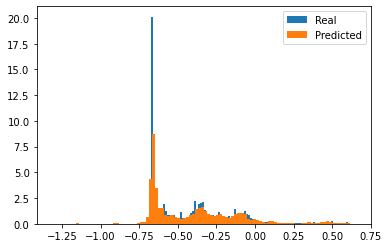

In [6]:
plt.rcParams['figure.figsize'] = [6, 4]
i = 3
a = plt.hist(signatures_Y['test'][:, i].numpy(), density = True, bins = 100, label = 'Real')
b = plt.hist(signatures_Y_pred['test'][:, i].numpy(), density = True, bins = 100, label='Predicted')
plt.legend()

Total number of parameters:      77089


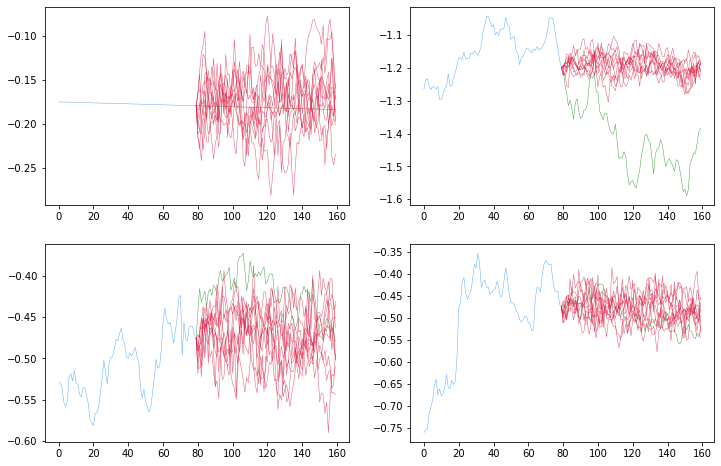

In [7]:
G = ConditionalGenerator(1, 1, 32, 5, 5, True).to('cuda')
print(f"Total number of parameters: {get_n_params(G):10}")

init_mult1 = 1
init_mult2 = 8
init_mult3 = 0.2
with torch.no_grad():
    for param in G.encoder.parameters():
        param *= init_mult1
        
    for param in G.cgenerator.parameters():
        param *= init_mult2
        
    for param in G.out.parameters():
        param *= init_mult3
        
plot(G=G, X_data=data['X_train'], Y_data=data['Y_train'], nsamples_fs=10, device='cuda')

In [8]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3)

In [9]:
hp = {'steps_per_print': 250, 'swa_step_start': 10000, 'nsamples_fs': 100, 'steps':10,
     'batch_size': 128}

In [10]:
train_dataset = TensorDataset(data['X_train'][:, :, 1:], signatures_Y_pred['train'])
train_dataloader = DataLoader(train_dataset, hp['batch_size'], shuffle=True)

val_dataset = TensorDataset(data['X_val'][:, :, 1:], signatures_Y_pred['val'])
val_dataloader = DataLoader(val_dataset, hp['batch_size'], shuffle=True)

test_dataset = TensorDataset(data['X_test'][:, :, 1:], signatures_Y_pred['test'])
test_dataloader = DataLoader(test_dataset, hp['batch_size'], shuffle=True)

In [11]:
channels_sig_Y = signatures_Y_pred['train'].shape[1]
print(f"The number of elements of the signature Y is {channels_sig_Y}")

The number of elements of the signature Y is 120


  0%|          | 0/10 [00:00<?, ?it/s]

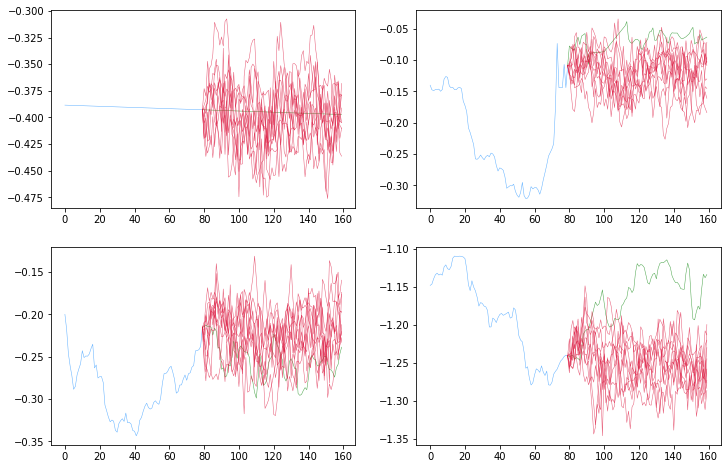

 10%|█         | 1/10 [00:24<03:36, 24.06s/it]

Step:    0 Val loss (unaveraged): 3.0017 Train_loss (unaveraged): 2.9047


 90%|█████████ | 9/10 [00:27<00:00,  1.13it/s]

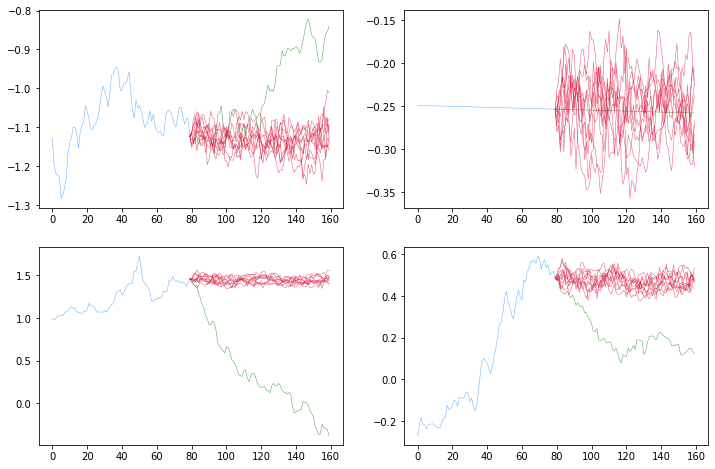

100%|██████████| 10/10 [00:50<00:00,  5.10s/it]


Step:    9 Val loss (unaveraged): 2.9780 Train_loss (unaveraged): 2.8819
Best validation loss: 2.9780 Test loss: 2.5349
Total time (in hours): 0.0173 Number of steps:     9
Maximum memory allocated (in MB): 9177.9261 Total number of parameters:      77089


In [12]:
G, G_optimizer = train_sigwgan(G, sig_Y, train_dataloader, val_dataloader, test_dataloader, hp, data['X_train'], data['Y_train'], 
                  G_optimizer, patience = 1000, epsilon = 0, max_time = 4)

In [14]:
save_model=False
if save_model:
    torch.save(G.state_dict(), 'G.pt')
    
load_model = True
if load_model:
    G.load_state_dict(torch.load('G.pt'))

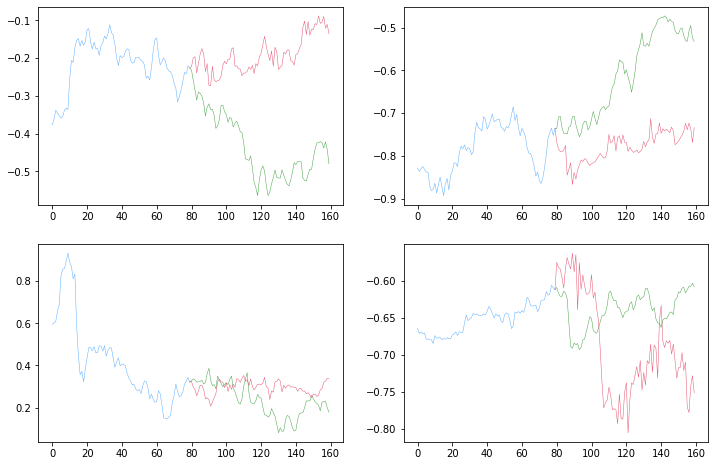

In [15]:
plot(G.to('cpu'), data['X_test'].cpu(), data['Y_test'].cpu(), nsamples_fs=1, device='cpu')

# Evaluation

In [16]:
from lib.Metrics import evaluate_performance, Evaluator

In [17]:
E = Evaluator(input_size = [1,1], hidden_size = [10,10], num_layers = [4,4], sep=data['X_train'].shape[1]).to(device)
data_e = data.copy()
for dataset in data_e:
    data_e[dataset] = data_e[dataset][:, :, 1:]

E_optimizer = torch.optim.Adam(E.parameters(), lr=1e-3)

hp_e = {'batch_size': 528, 'steps': 10000, 'steps_per_print': 500, 'E_optimizer': E_optimizer}

E = evaluate_performance(E, G, data_e, hp_e, sig_X = None, device='cuda', generator = 'lstm', print_=False)

Training samples:  14000  Validation samples:  3000  Test samples:  3000


100%|██████████| 10000/10000 [06:56<00:00, 24.01it/s]

AUC: 0.7964 Accuracy: 0.7070


### Extreme values metric

In [18]:
from lib.Metrics import trading_metric, summary_statistics

In [19]:
test_pred_buying, test_real_buying = trading_metric(data['X_test'], data['Y_test'], G, 1000, 10, alpha=0.25, pct = False, 
                                                    type_='buying', generator = 'lstm', device='cuda')

test_pred_selling, test_real_selling = trading_metric(data['X_test'], data['Y_test'], G, 1000, 10, alpha=-0.27, pct = False, 
                                                      type_='selling', generator = 'lstm', device='cuda')

In [20]:
summary_statistics(test_pred_buying, test_real_buying)

The ROC AUC score is 0.4680


In [21]:
summary_statistics(test_pred_selling, test_real_selling)

The ROC AUC score is 0.5240


### Unconditional Distribution

In [22]:
from lib.Metrics import distribution_metric

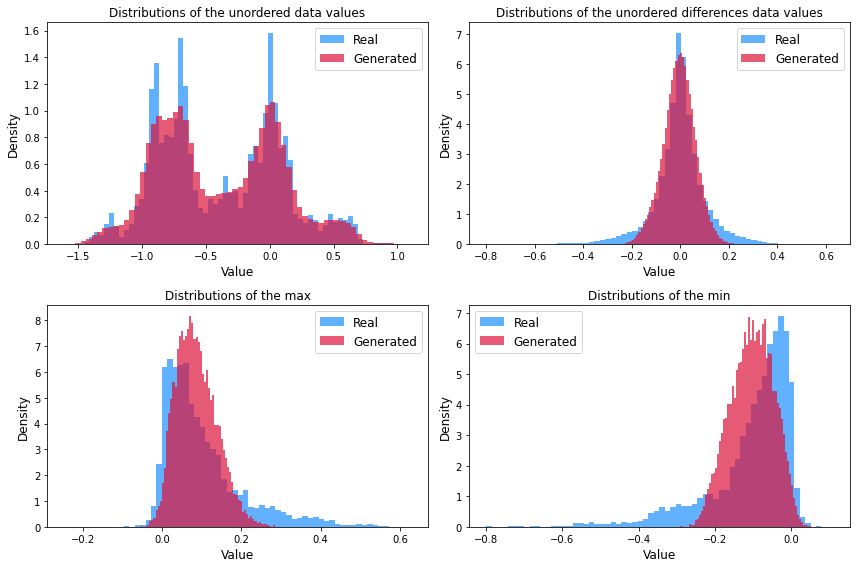

The Wasserstein-1 distance between the real and generated distributions is 0.0115
The Wasserstein-1 distance between the real and generated difference distributions is 0.0217
The Wasserstein-1 distance between the real and generated max distributions is 0.0317
The Wasserstein-1 distance between the real and generated min distributions is 0.0396


In [23]:
distribution_metric(data['X_test'][:, :, 1:].to(device), data['Y_test'][:, :, 1:].to(device), G.to(device), 
                    sig_X = None, 
                    generator='lstm', log=False, inc = False, stats=None)

### Signature metric

In [24]:
from lib.Metrics import signature_metric

In [25]:
signature_metric(data, G, 6, 5, 100, 100, 'lstm', normalize=True, device='cuda')

MSE train: 0.5104 MSE val: 0.4740 MSE test: 0.7076
The signature-wasserstein metric loss is 3.0085
